# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [84]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [85]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [86]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 18,norm='l1',alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
            
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
       
    
    # Add another vectorized set of words, but this time add ngrams
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 18,strip_accents='ascii',stop_words='english',ngram_range=(1, 1),alternate_sign=False)
        hv2 = HashingVectorizer(n_features=2 ** 18,ngram_range=(1, 5),norm='l1',analyzer='word',stop_words="english",tokenizer=LemmaTokenizer(),alternate_sign=False)
        X_hv2 = hv2.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv2)
        print("Shape of HashingVectorizer X:")
        print(X_hv2.shape)
    else: # transform() 
        X_hv2 = fitted_transformations[2].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv2.shape)
    
    
    
#     # Add letter ngrams
#     if (not test): # fit_transform()
# #         hv = HashingVectorizer(n_features=2 ** 18,strip_accents='ascii',stop_words='english',ngram_range=(1, 1),alternate_sign=False)
#         hv3 = HashingVectorizer(n_features=2 ** 18,ngram_range=(3, 6),analyzer='char_wb',alternate_sign=False)
#         X_hv3 = hv.fit_transform(toxic_data.comment_text)
#         fitted_transformations.append(hv3)
#         print("Shape of HashingVectorizer X:")
#         print(X_hv3.shape)
#     else: # transform() 
#         X_hv3 = fitted_transformations[3].transform(toxic_data.comment_text)
#         print("Shape of HashingVectorizer X:")
#         print(X_hv3.shape)
    
    
    
    
    
    # create additional quantitative features
    # count punctuation
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count1'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['punc_count3'] = toxic_data['comment_text'].str.count("\?")
    # count uppercase letters
    # https://stackoverflow.com/questions/18129830/count-the-uppercase-letters-in-a-string-with-python
    toxic_data['uppc_count'] = len(re.findall(r'/([A-Z]){3,}/',str(toxic_data['comment_text'])))

        
    X_quant_features = toxic_data[["word_count", "punc_count1","punc_count2","punc_count3"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))

#     X_quant_features = toxic_data[["word_count", "punc_count"]]
#     print("Look at a few rows of the new quantitative features: ")
#     print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_hv2,  X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[3].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [87]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../final_data/toxiccomments_train.csv', my_random_seed=555)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

C:\Users\antho\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Shape of HashingVectorizer X:
(159571, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count1  punc_count2  punc_count3
0          42            5            0            1
1          18            2            1            0
2          42            3            0            0
3         112            3            0            0
4          13            1            0            1
5          12            1            0            0
6           8            0            0            0
7          21            2            0            0
8          83            7            0            1
9          12            0            0            0
Size of combined bag of words and new quantitative variables matrix:
(159571, 524292)
(159571, 524292)
Shape of X_train and X_test:
(127656, 524292)
(31915, 524292)
Shape of y_train and y_test:
(127656,)
(31915,)
Shape of X_raw_train and X_raw_test:
(127656, 14)
(31915, 14)
SUCCESS!
Number of fits stored in `fitted

# Fit (and tune) Various Models

In [88]:
### MODEL: ordinary least squares

# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

In [89]:
# MODEL: SVM, linear
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12975, 'TN': 114670, 'FP': 9, 'FN': 2, 'Accuracy': 0.9999138309205992, 'Precision': 0.9993068391866913, 'Recall': 0.9998458811743854, 'desc': 'svm_train'}


In [90]:
# MODEL: logistic regression

from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log',penalty='l1',alpha=0.0002)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12404, 'TN': 114442, 'FP': 237, 'FN': 573, 'Accuracy': 0.9936548223350253, 'Precision': 0.9812514832687287, 'Recall': 0.9558449564614317, 'desc': 'lgs_train'}


C:\Users\antho\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [91]:
# MODEL: Naive Bayes
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB
# from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
# nbs = MultinomialNB()
nbs = ComplementNB(alpha=30,norm=True)

nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 8966, 'TN': 114539, 'FP': 140, 'FN': 4011, 'Accuracy': 0.9674829228551732, 'Precision': 0.9846255216340875, 'Recall': 0.6909146952300224, 'desc': 'nbs_train'}


In [92]:
# MODEL: Perceptron

from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron',penalty='elasticnet')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12968, 'TN': 114670, 'FP': 9, 'FN': 9, 'Accuracy': 0.9998589960518894, 'Precision': 0.9993064652847345, 'Recall': 0.9993064652847345, 'desc': 'prc_train'}


In [93]:
# MODEL: Ridge Regression Classifier

from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True, alpha=5)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12977, 'Neg': 114679, 'TP': 12966, 'TN': 111542, 'FP': 3137, 'FN': 11, 'Accuracy': 0.9753399761859999, 'Precision': 0.8051915792088431, 'Recall': 0.99915234645912, 'desc': 'rdg_train'}


In [94]:
# MODEL: Random Forest Classifier

# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

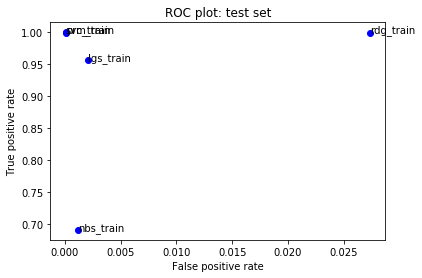

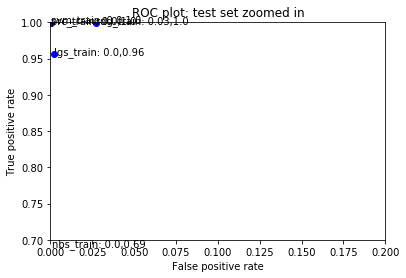

In [95]:
# ROC plot to compare performance of various models and fits

# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits = [ svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, .2, 0.7, 1])
# plt.ylim(0.5, 1)
# plt.xlim(0.5,1)
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc +': '+str(round(fit.performance_measures['FP'] / fit.performance_measures['Neg']*100)/100) +','+ str(round(fit.performance_measures['TP'] / fit.performance_measures['Pos']*100)/100) )
plt.axis([0, .2, 0.7, 1])
# plt.ylim(0.5, 1)
# plt.xlim(0.5,1)
plt.title('ROC plot: test set zoomed in')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [96]:
# ols_predictions = ols.predict(X_train)
# svm_predictions = svm.predict(X_train)
# lgs_predictions = lgs.predict(X_train)
# the_preds = nbs.predict(X_train)
# prc_predictions = prc.predict(X_train)
the_preds = rdg.predict(X_train)

In [97]:
# let's look at some false positives:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(the_preds)):
    if (the_preds[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
3069
a

Never gonna give you up Never gonna let you down Never gonna run around and desert you Never gonna make you cry Never gonna say goodbye Never gonna tell a lie and hurt you.
* * * * * * * * * 
3263
Good morning. 
 
Why do you sit at a computer waiting to delete other peoples' additions? The topic I uploaded was of a fictional organisation whose comedy nature DOES appeal to those people blessed with a pulse. Before any of us here could edit/link or expand our article...you deleted it.

We may sound childish, however, we cannot beleive that there are people as pathetic as you lording yourself around the internet. It was people like you, sir, who were responsible for carrying every major dictator and despot of the last century to power on a wave of apathy, ill-humour and rubber-desk-johnny procedure-bound mentral dross. You are, by any reasonable and objective measure, worse than Stalin. You are the reason this world is full of crashing bores!

Please d

28631
"

 Not I; I just don't like being forcibly separated from friends and never being able to find my way back; always some damn referendum or something.   (Talk) "
* * * * * * * * * 
31026
Non Treaty Chippewa Indians
I pity you white cowards. I am going through this sick cowardly conspiracy only to have a coward intrude to stop the truth from being known. You whites are so determined and proud to prove you are even bigger cowards. I feel great sorrow for your race for you have not a bit of courage. I strongly adivse you to be strong emotionally for it will improve your outlook on cooperating. Go ahead and resort to the cowards way and delete my page (Non Treaty Chippewa Indians).

If an entity looking out for the future of Native Americans is involved, i hope they kill you and those close to you, in the most gruesome of manners. Where is your courage? Bring forth your courage by deleting my page (Non Treaty Chippewa Indians). That will prove you have the courage to accept the inevi

50995
Alphabetisation 

Just being a little pedantic, but when alphabetised in lists (such as Categories:Doctor Who serials) '100,000' is placed under 'O' for 'One hundred thousand'.  Let's be a bit professional about this.
* * * * * * * * * 
52453
Getting rid of time stamps  

STOP MAKING THIS CHANGE ON PLAYERS PROFILES! IT IS FINE AS IT IS AND DOES NOT NEED CHANGING. UNDOING YOUR POINTLESS EDITS IS VERY ANNOYING TO PEOPLE! YOU HAVE BEEN TOLD ABOUT THIS BY OTHER MEMBERS AS WELL. STOP IT OR FACING ACTION FROM WIKIPEDIA!!!
* * * * * * * * * 
53690
Sexuality has several meanings, including sexuality (sexual orientation) and human sexuality, which seems to be more about behavior.  He not only changed his sexual orientation, from gay to bisexual, but he also changed his sexual behavior.  Same-sex attraction is only one small part of sexuality.
* * * * * * * * * 
54496
You know 

You're really crushing me! 173.97.227.106
* * * * * * * * * 
55018
You really need a life dude.
* * * * * * * * 

83193
About the LEGO Scooby-Doo Doo airing on Teletoon. 

I RECORDED the episode myself that day do I know it was that day. It's not my fault you can't Google it yourself to confirm.
* * * * * * * * * 
87970
I mam sure you do not wish to be part of Vigilance's hate group. This pedophile loving, sorry girlloving, user just cant help himslef. That is okay, we'll help him for you (wikipedia). I don't think anyone thinks you are a paedophile SGGH, just naive young man, lets face it, would you be seen dead with a girllover? ie arm in arm with a paedophile, like Ssbohio tried to out some poor innocent girl recently. Hope not.
* * * * * * * * * 
88768
"

 Harassment 

Christian1985 has been repeatedly harassing me every since I rejected his advances. I respect him, but I am not gay, and I dont think what he does is right. Be careful other people, and never give him your personal email address, he doesn't take no for an answer.  —Preceding unsigned comment added by 88.16.129.201   "
* * * * * 

108426
hey andy 

u r a wanka
* * * * * * * * * 
109942
Your behavier is a disgrace to wikipedia.
* * * * * * * * * 
110076
Again, KUDOS for advancing the Democratic cause on Wikipedia!  But if that's something you're ashamed of, you should go ahead and ban me.
* * * * * * * * * 
111018
Only a fool turns his back on history.
* * * * * * * * * 
111999
Everything's LOOSE!!!!  I SAY LOOSE!!!
* * * * * * * * * 
112023
your comments circa my talk page response 

an interesting set of invalidations and assertations, not any of which are true.

The only one worth commenting on.

There is a special loophole that allows states to force the issue of impeachment to be heard. Sorry you hadn't heard of the loophole.
Quit being intentionally ignorant, accidentally lying, and go bother to
read the articles provided.
* * * * * * * * * 
112192
Why should I do that? Nobody says its a must here and I don't think it is. 
About Tocino: I think he should be stopped with his POV Contributions? Wouldn't it be

In [98]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(the_preds)):
    if (the_preds[i] == 0):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
#             if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false negatives:
42334
WELCOME, BITCH

Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are a few good links for newcomers:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and someone will show up shortly to answer your questions. Again, welcome!
* * * * * * * * * 
45294
"
 The various local government areas pages only list them.  I was thinking something like that.  These three paragraphs are from a couple of papers I wrote, they can be incorporated into the article.  

The states (and territories) run the majority of the government in Australia and d

101629
I have no idea why you are posting the slang definitions of 'fuck'.  That is a total non-sequitur.  I have not seen anyone here assert that there aren't any ways of using 'fuck' that are slang.  The point was, and remains, that the standard use of the word 'fuck' as both a noun and a verb - the only ways that this word has been used in this entire discussion throughout this entire week up until your latest post - has been the standard definition that is widely understood and accepted as a normal word that is nowhere near slang.

You used this non-sequitur as your basis for reversion.  And to this day you are persisting in it.  Yet again another example of a huge logic disconnect that permeates this entire exchange.

As for the meta-discussion (the discussion about the discussion), Andy's revert was based upon his assessment that the issue needed to be discussed before such a change could be accepted.  And where did he choose to raise that discussion?  Over on my User Talk page. 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

In [99]:
# MODEL: ordinary least squares
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

In [100]:
# MODEL: SVM, linear
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 1602, 'TN': 27725, 'FP': 942, 'FN': 1646, 'Accuracy': 0.9189096036346546, 'Precision': 0.6297169811320755, 'Recall': 0.4932266009852217, 'desc': 'svm_test'}


In [101]:
# MODEL: logistic regression
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 1716, 'TN': 25893, 'FP': 2774, 'FN': 1532, 'Accuracy': 0.8650791164029453, 'Precision': 0.3821826280623608, 'Recall': 0.5283251231527094, 'desc': 'lgs_test'}


In [102]:
# MODEL: Naive Bayes
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 526, 'TN': 28315, 'FP': 352, 'FN': 2722, 'Accuracy': 0.9036816543944853, 'Precision': 0.5990888382687927, 'Recall': 0.16194581280788178, 'desc': 'nbs_test'}


In [103]:
# MODEL: Perceptron
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 1784, 'TN': 27670, 'FP': 997, 'FN': 1464, 'Accuracy': 0.9228889237035877, 'Precision': 0.6414958647968356, 'Recall': 0.5492610837438424, 'desc': 'prc_test'}


In [104]:
# MODEL: Ridge Regression Classifier
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3248, 'Neg': 28667, 'TP': 2880, 'TN': 24926, 'FP': 3741, 'FN': 368, 'Accuracy': 0.8712517624941251, 'Precision': 0.43497961033076576, 'Recall': 0.8866995073891626, 'desc': 'rdg_test'}


In [105]:
# MODEL: Random Forest Classifier
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

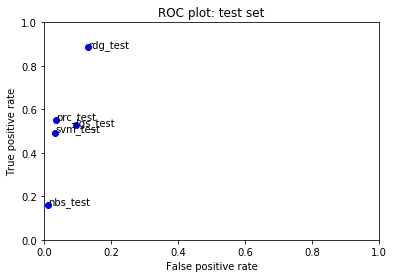

In [106]:
# ROC plot to compare performance of various models and fits

# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
# fits = [svm_performance_test,  nbs_performance_test,  rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
plt.axis([0, 1, 0, 1])
# plt.axis([0, 0.3, 0.5, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc +': '+str(round(fit.performance_measures['FP'] / fit.performance_measures['Neg']*100)/100) +','+ str(round(fit.performance_measures['TP'] / fit.performance_measures['Pos']*100)/100) )
    
# # plt.axis([0, 1, 0, 1])
# plt.axis([0, 0.3, 0.4, 1])
# plt.title('ROC plot: test set zoomed in')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [107]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../final_data/toxiccomments_test.csv', my_random_seed=555, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 262144)
Shape of HashingVectorizer X:
(153164, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count1  punc_count2  punc_count3
0          72           10            0            0
1          13            1            0            0
2          16         

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [108]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# my_submission["prediction"] = ols.predict(X_test_submission)
# my_submission["prediction"] = svm.predict(X_test_submission)
# my_submission["prediction"] = lgs.predict(X_test_submission)
# my_submission["prediction"] = prc.predict(X_test_submission)
my_submission["prediction"] = rdg.predict(X_test_submission)

# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.3291243373116398


In [109]:
raw_data.head()

,id,comment_text,word_count,punc_count1,punc_count2,punc_count3,uppc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,0,0


In [110]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [111]:
my_submission.shape

(153164, 2)

In [112]:
# export submission file as pdf
# CHANGE FILE PATH: 
# my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)
my_submission.to_csv('../final_data/toxiccomments_submission_draft2.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation